In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data
import torchvision
from torchvision import transforms
from PIL import Image

import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from skorch import NeuralNet

from sklearn.datasets import make_regression
from skorch import NeuralNetRegressor



In [2]:
cifar_data = torchvision.datasets.CIFAR10('data/cifar-10/', train=True, download=True)
cifar_testing = torchvision.datasets.CIFAR10('data/cifar-10/', train=False, download=True)


Files already downloaded and verified
Files already downloaded and verified


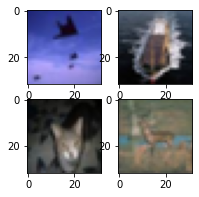

In [3]:
# visualizing 4 random images
fig = plt.figure(figsize=(3,3))
cols, rows = 2, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(cifar_data), size=(1,)).item()
    img, label = cifar_data[sample_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img, cmap="gray")
plt.show()

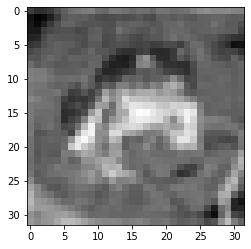

In [4]:
#U, sigma, V = np.linalg.svd(cifar_data[0])
img, label = cifar_data[0]
g_img = img.convert('LA')
plt.figure(figsize=(6, 4))
plt.imshow(g_img) # plot image onto 


In [5]:
x = np.array(list(g_img.getdata(band=0)), float)
g_img = img.convert('LA')


In [6]:
# search for existing data
try:
    print('Finding Existing Data')
    image_matrices = np.load('data/Matrix_gens/cifar_10_data/cifar_10_mat.npy')
    image_singular = np.load('data/Matrix_gens/cifar_10_data/cifar_10_singular.npy')
    ranks = np.load('data/Matrix_gens/cifar_10_data/cifar_10_ranks.npy')

    test_image_matrices = np.load('data/Matrix_gens/cifar_10_data/cifar_10_tests.npy')
    test_image_singular = np.load('data/Matrix_gens/cifar_10_data/cifar_10_tests_singular.npy')
    print('Data Found')
except:
    # placing values of image into matrices

    # arrays only used for integration  
    print('Data not found... Creating NP Arrays')
    arr_mat = []
    arr_singular = []
    arr_ranks = []

    for i in range(len(cifar_data)):
        img, label = cifar_data[i]
        g_img = img.convert('LA')
        x = list(img.getdata(band=0))

        matrix = np.array(x, float)
        matrix.shape = (g_img.size[1], g_img.size[0])
        matrix = np.matrix(matrix)

        # svd and rank of image
        U, sigma, V = np.linalg.svd(matrix) # computes the SVD
        rank = np.linalg.matrix_rank(matrix, tol=0.001)
        
        arr_mat.append(matrix)
        arr_singular.append(sigma)
        arr_ranks.append(rank)

    

    # final Numpy matrices used for training
    image_matrices = np.array(arr_mat)
    image_singular = np.array(arr_singular)
    ranks = np.array(arr_ranks)
    np.save('data/Matrix_gens/cifar_10_data/cifar_10_mat.npy', image_matrices)
    np.save('data/Matrix_gens/cifar_10_data/cifar_10_singular.npy', image_singular)
    np.save('data/Matrix_gens/cifar_10_data/cifar_10_ranks.npy', ranks)

    # testing sets
    arr_mat_1 = []
    arr_singular_1 = []
    arr_ranks_1 = []
    for i in range(len(cifar_testing)):
            img, label = cifar_testing[i]
            g_img = img.convert('LA')
            x = list(img.getdata(band=0))

            matrix = np.array(x, float)
            matrix.shape = (g_img.size[1], g_img.size[0])
            matrix = np.matrix(matrix)

            # svd and rank of image
            U, sigma, V = np.linalg.svd(matrix) # computes the SVD
            rank = np.linalg.matrix_rank(matrix, tol=0.001)

            arr_mat_1.append(matrix)
            arr_singular_1.append(sigma)
            arr_ranks_1.append(rank)

    test_image_matrices = np.array(arr_mat_1)
    test_image_singular = np.array(arr_singular_1)
    test_ranks = np.array(arr_ranks_1)

    np.save('data/Matrix_gens/cifar_10_data/cifar_10_tests.npy', test_image_matrices)
    np.save('data/Matrix_gens/cifar_10_data/cifar_10_tests_singular.npy', test_image_singular)
        

Finding Existing Data
Data Found


In [7]:
"""arr_mat_1 = []
arr_singular_1 = []
arr_ranks_1 = []
for i in range(len(cifar_testing)):
        img, label = cifar_testing[i]
        g_img = img.convert('LA')
        x = list(img.getdata(band=0))

        matrix = np.array(x, float)
        matrix.shape = (g_img.size[1], g_img.size[0])
        matrix = np.matrix(matrix)

        # svd and rank of image
        U, sigma, V = np.linalg.svd(matrix) # computes the SVD
        rank = np.linalg.matrix_rank(matrix, tol=0.001)

        arr_mat_1.append(matrix)
        arr_singular_1.append(sigma)
        arr_ranks_1.append(rank)

test_image_matrices = np.array(arr_mat_1)
test_image_singular = np.array(arr_singular_1)
test_ranks = np.array(arr_ranks_1)

np.save('Matrix_gens/cifar_10_data/cifar_10_tests.npy', test_image_matrices)
np.save('Matrix_gens/cifar_10_data/cifar_10_tests_singular.npy', test_image_singular)"""

"arr_mat_1 = []\narr_singular_1 = []\narr_ranks_1 = []\nfor i in range(len(cifar_testing)):\n        img, label = cifar_testing[i]\n        g_img = img.convert('LA')\n        x = list(img.getdata(band=0))\n\n        matrix = np.array(x, float)\n        matrix.shape = (g_img.size[1], g_img.size[0])\n        matrix = np.matrix(matrix)\n\n        # svd and rank of image\n        U, sigma, V = np.linalg.svd(matrix) # computes the SVD\n        rank = np.linalg.matrix_rank(matrix, tol=0.001)\n\n        arr_mat_1.append(matrix)\n        arr_singular_1.append(sigma)\n        arr_ranks_1.append(rank)\n\ntest_image_matrices = np.array(arr_mat_1)\ntest_image_singular = np.array(arr_singular_1)\ntest_ranks = np.array(arr_ranks_1)\n\nnp.save('Matrix_gens/cifar_10_data/cifar_10_tests.npy', test_image_matrices)\nnp.save('Matrix_gens/cifar_10_data/cifar_10_tests_singular.npy', test_image_singular)"

In [8]:
image_matrices.shape

(50000, 32, 32)

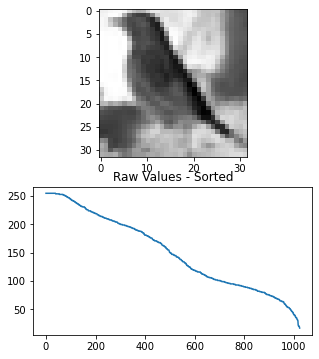

In [9]:
# testing validity of np arrays
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(5,6))

random_int = np.random.randint(50000)

img = image_matrices[random_int]
rank = np.linalg.matrix_rank(img, tol=50)
axs[0].imshow(img, cmap='gray') # plot image onto 
#rank
axs[1].set_title('Raw Values - Sorted')
axs[1].plot(np.sort(img.flatten())[::-1])

In [10]:
ranks

array([32, 32, 32, ..., 32, 32, 32], dtype=int64)

In [11]:
# creating subclass to create dataset for training
class CifarDataset(torch.utils.data.Dataset):
    def __init__(self, images, singular):
        self.X = images
        self.Y = singular
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    def __len__(self):
        return len(self.X)


In [12]:
class RegressorModule(nn.Module):
    def __init__(self, num_units=5000, nonlin=F.relu): # why this param list
        super(RegressorModule, self).__init__()
        self.num_units = num_units
        self.nonlin = nonlin

        self.dense0 = nn.Linear(1024, num_units)
        #self.dropout0 = nn.Dropout(0.7)
        self.dense1 = nn.Linear(num_units,750)
        self.dropout = nn.Dropout(0.7)
        self.dense2 = nn.Linear(750, 300)
        self.dropout2 = nn.Dropout(0.7)
        self.dense3 = nn.Linear(300, 100)
        self.output = nn.Linear(100, 32)

    def forward (self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        #X = self.dropout0(X)
        X = self.nonlin(self.dense1(X))
        X = self.dropout(X)
        X = self.nonlin(self.dense2(X))
        X = self.dropout2(X)
        X = self.nonlin(self.dense3(X))
        X = self.nonlin(self.output(X))
        #X = F.softmax(self.output(X), dim=-1)
        return X

net = NeuralNetRegressor(
    RegressorModule, # pytorch module
    #train_split=None,
    criterion = nn.L1Loss, 
    max_epochs=512,
    lr=0.0001,
    device='cuda',
)

In [13]:
image_matrices[0]

array([[ 59.,  43.,  50., ..., 158., 152., 148.],
       [ 16.,   0.,  18., ..., 123., 119., 122.],
       [ 25.,  16.,  49., ..., 118., 120., 109.],
       ...,
       [208., 201., 198., ..., 160.,  56.,  53.],
       [180., 173., 186., ..., 184.,  97.,  83.],
       [177., 168., 179., ..., 216., 151., 123.]])

In [14]:
flattened = np.reshape(image_matrices, (50000, 1024))
flattened = flattened.astype(np.float32)
image_singular = image_singular.astype(np.float32)


In [15]:
train_data = CifarDataset(images=flattened, singular=image_singular)
#net.fit(X=train_data[:][0],y=train_data[:][1])
net.fit(train_data, None)
# for the future, use dataloader

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1      182.0887       53.4705  1.6908
      2       68.2234       47.9097  1.3099
      3       61.7311       47.0125  1.3007
      4       58.0098       46.7672  1.2880
      5       55.9521       41.4334  1.3150
      6       54.3402       40.6598  1.2882
      7       53.5218       39.7597  1.2876
      8       52.7122       39.0260  1.2848
      9       51.9906       40.7553  1.2912
     10       51.6630       38.8910  1.3020
     11       51.1237       39.2842  1.2941
     12       50.9890       39.1595  1.3020
     13       50.6316       39.7093  1.3286
     14       50.4293       38.5404  1.4062
     15       50.0856       41.4469  1.3900
     16       49.8017       41.6195  1.4002
     17       49.5876       38.6739  1.3494
     18       49.3377       39.1632  1.3812
     19       49.2419       40.2244  1.4442
     20       48.8695       38.1446  1.4256
     21       48.7101       37.5

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=RegressorModule(
    (dense0): Linear(in_features=1024, out_features=5000, bias=True)
    (dense1): Linear(in_features=5000, out_features=750, bias=True)
    (dropout): Dropout(p=0.7, inplace=False)
    (dense2): Linear(in_features=750, out_features=300, bias=True)
    (dropout2): Dropout(p=0.7, inplace=False)
    (dense3): Linear(in_features=300, out_features=100, bias=True)
    (output): Linear(in_features=100, out_features=32, bias=True)
  ),
)

In [ ]:
#net.save_params(f_params='models/cifar-10-model.pkl')

## Visualization

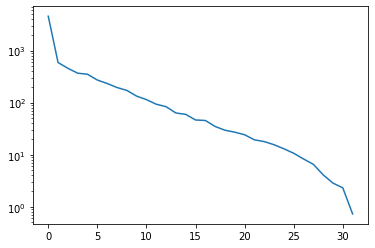

In [ ]:
plt.semilogy(image_singular[0])

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn import preprocessing

In [ ]:
#testing = CifarDataset(test_image_matrices,test_)
testing = np.reshape(test_image_matrices, (10000, 1024))
testing = testing.astype(np.float32)
y_pred = net.predict(testing)

In [ ]:
test_image_singular[0]
y_pred

array([[3485.884  ,  535.3531 ,  437.04636, ...,    0.     ,    0.     ,
           0.     ],
       [4857.2456 ,  858.247  ,  541.595  , ...,    0.     ,    0.     ,
           0.     ],
       [4126.317  ,  567.36237,  370.7679 , ...,    0.     ,    0.     ,
           0.     ],
       ...,
       [2483.6917 ,  607.3581 ,  451.5872 , ...,    0.     ,    0.     ,
           0.     ],
       [3281.5464 ,  889.1745 ,  697.8107 , ...,    0.     ,    0.     ,
           0.     ],
       [3400.5205 ,  671.5811 ,  435.44937, ...,    0.     ,    0.     ,
           0.     ]], dtype=float32)

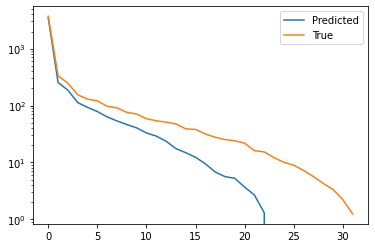

In [ ]:
randint = np.random.randint(10000)

x = (y_pred[randint][:])
x = np.sort(x)[::-1]
plt.semilogy(x, label='Predicted')
plt.semilogy(test_image_singular[randint][:], label='True')
plt.legend()


In [ ]:
x,test_image_singular[randint][:]

(array([3193.8977   ,  932.5911   ,  575.8105   ,  314.19214  ,
         253.67773  ,  213.93236  ,  174.98843  ,  147.0903   ,
         123.41324  ,  108.302666 ,   91.3191   ,   79.103966 ,
          66.675514 ,   50.125294 ,   41.83061  ,   36.090805 ,
          28.976353 ,   24.432543 ,   20.182016 ,   16.232897 ,
          12.828349 ,   12.719917 ,   10.076773 ,    9.8939705,
           7.3068705,    0.       ,    0.       ,    0.       ,
           0.       ,    0.       ,    0.       ,    0.       ],
       dtype=float32),
 array([3.45660613e+03, 9.91234946e+02, 5.18987967e+02, 4.78929475e+02,
        3.57027194e+02, 3.01385133e+02, 2.09994132e+02, 1.69005815e+02,
        1.52130942e+02, 1.34320070e+02, 1.04905038e+02, 8.52572396e+01,
        7.41499916e+01, 5.99363422e+01, 5.85687842e+01, 4.91283952e+01,
        4.75773071e+01, 3.58821076e+01, 2.90250009e+01, 2.45575735e+01,
        2.17734537e+01, 2.05525599e+01, 1.73610945e+01, 1.16706032e+01,
        1.00401403e+01, 9.248059

In [ ]:
torch.save(RegressorModule,'models/singular_model_nodrop.pkl')
net.save_params(f_params='models/singular_trained_nodrop.pkl')